# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
from fastai.text import *
from transformer_xl.default_txl import get_default_model
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
from fastai_data import *

In [5]:
import numpy as np
import torch.nn as nn

In [6]:
from ht_encode import *
import ht_encode

In [7]:
bs=8
bptt=24

In [8]:
import fastai_data
fastai_data.Y_OFFSET=1

In [9]:
path = Path('data/midi/v7/midi_encode/np/hook_noinv/')
# data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/sample')
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/all')

In [10]:
config = tfmerXL_lm_config

In [11]:
PAD_IDX=ht_encode.config.pad_idx+ht_encode.config.enc_offset

In [12]:
train_ids_file = path/'tmp/all/train_ids.npy'
all_ids = np.load(train_ids_file)
id_cat = np.concatenate(all_ids); id_cat.shape
ax = tuple(range(len(id_cat.shape)-1))
max_vocab = id_cat.max(axis=ax)
max_vocab = (max_vocab+1).tolist(); max_vocab

[7, 12, 15, 13, 5, 15, 15, 15, 15, 5, 7]

In [13]:

# ENC_IDXS = [0,1,2,3,4,5,6,7,8,9,10]
# iB,iM,iN,iNO,iND,iC1,iC2,iC3,iC4,iCD,iCI = ENC_IDXS
# CIDXS = [iC1,iC2,iC3,iC4]
# CIDX_ALL = CIDXS + [iCD,iCI]
# NIDX_ALL = [iN,iNO,iND]
# BIDX_ALL = [iB,iM]

In [14]:
N_BAR = 16
N_COMPS = 9
N_EMBS = 20

In [15]:
EMB_IDXS = [0,1,2,3,4,5]
EMB_DIM = [N_EMBS]*len(EMB_IDXS)
VOCAB_SZ = [max_vocab[i] for i in [iN,iNO,iND,iCI,iB,iM]]
EMB_MAP = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
eN,eO,eD,eI,eB,eM = EMB_MAP

In [16]:
idx2embidx = {
    iN:eN,iNO:eO,iND:eD,
    iC1:eN,iC2:eN,iC3:eN,iC4:eN,iCD:eD,iCI:eI,
    iB:eB,
    iM:eM
}

In [17]:
EMB_MAP

[(0, 15, 20), (1, 13, 20), (2, 5, 20), (3, 7, 20), (4, 7, 20), (5, 12, 20)]

In [18]:
config['emb_map'] = EMB_MAP
config['idx_map'] = idx2embidx

In [19]:
total_embs = sum([v[-1] for k,v in idx2embidx.items() if k not in [iB,iM]])
config['d_model'] = total_embs * N_BAR

In [20]:
config['ctx_len'] = 0
config['mem_len'] = 256
# config['d_inner'] = 1024 * N_BAR
config['d_inner'] = config['d_model'] * 2

In [21]:
config['timesteps'] = N_BAR

In [22]:
# config

In [26]:
class TransformerEmbed(nn.Module):
    def __init__(self, emb_map, idx_map, embed_p:float=0.1, **kwargs):
        super().__init__()
        # note, octave, duration, instrument
        self.idx_map = idx_map
        self.emb_map = emb_map
        embeddings = []
        for idx,in_d,out_d in emb_map:
            embeddings.append(nn.Embedding(in_d, out_d, padding_idx=PAD_IDX))
        self.embeddings = nn.ModuleList(embeddings)
        self.drop_emb = nn.Dropout(embed_p)
        
    def forward(self, x):
        # batch x bptt x (n,o,d,i)
        pos_enc = self.embeddings[eB[0]](x[...,iB]) + self.embeddings[eM[0]](x[...,iM])
        embs = []
        for i in range(x.shape[-1]):
            emb_idx = self.idx_map[i][0]
            if i in [iB,iM]: continue
            embx = self.embeddings[emb_idx](x[...,i])
            embs.append(embx + pos_enc)
        emb = torch.stack(embs, dim=-2) # barlen x comp x emb
#         emb = emb.permute(0,1,4,2,3) # for conv - emb x barlen x comp
        emb = emb.view(*emb.shape[:2], -1) # flatten completely
        return self.drop_emb(emb)

In [27]:
class DownConv(nn.Module):
    def __init__(self, d_model):
        pass

In [28]:
class TXLLinearDecoder(nn.Module):
    "To go on top of a RNNCore module and create a Language Model."
    initrange=0.1

    def __init__(self, n_out:int, n_hid:int, tie_encoder:nn.Module=None, bias:bool=True):
        super().__init__()
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight

    def forward(self, input):
        return self.decoder(input)

In [29]:
idx2embidx.items()

dict_items([(2, (0, 15, 20)), (3, (1, 13, 20)), (4, (2, 5, 20)), (5, (0, 15, 20)), (6, (0, 15, 20)), (7, (0, 15, 20)), (8, (0, 15, 20)), (9, (2, 5, 20)), (10, (3, 7, 20)), (0, (4, 7, 20)), (1, (5, 12, 20))])

In [30]:
class TransformerDec(nn.Module):
    def __init__(self, txl_emb, idx_map, output_p=0.0, out_bias=True, **kwargs):
        super().__init__()
        self.output_dp = RNNDropout(output_p)
        
        decoders = []
        for k,v in idx_map.items():
            if k in [iB,iM]: continue
            emb = txl_emb.embeddings[v[0]]
            decoder = TXLLinearDecoder(emb.num_embeddings, emb.embedding_dim, tie_encoder=emb, bias=out_bias)
            decoders.append(decoder)
            
        self.decoders = nn.ModuleList(decoders)
        
    def forward(self, input):
        raw_outputs, outputs = input
        output = self.output_dp(outputs[-1])
        output = output.view(*output.shape[:-1], N_BAR, N_COMPS, N_EMBS)
        res = []
        for idx,dec in enumerate(self.decoders):
            res.append(dec(output[...,idx,:]))
        return res, raw_outputs, outputs

In [31]:

class LMNPTransformerXL(nn.Module):
    "TransformerXL model: https://arxiv.org/abs/1901.02860."
    def __init__(self, encoder, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=False, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadRelativeAttention,
                 learned_pos_enc:bool=False, mask:bool=True, mem_len:int=0, **kwargs):
        super().__init__()
        self.encoder = encoder
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.u = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.v = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.mem_len,self.n_layers,self.d_model,self.mask = mem_len,n_layers,d_model,mask
        self.init = False
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                      attn_cls=attn_cls) for k in range(n_layers)])
    
    def reset(self):
        "Reset the internal memory."
        self.hidden = [next(self.parameters()).data.new(0) for i in range(self.n_layers+1)]

    def _update_mems(self, hids):
        if not getattr(self, 'hidden', False): return None
        assert len(hids) == len(self.hidden), 'len(hids) != len(self.hidden)'
        with torch.no_grad():
            for i in range(len(hids)):
                cat = torch.cat([self.hidden[i], hids[i]], dim=1)
                self.hidden[i] = cat[:,-self.mem_len:].detach()
    
    def select_hidden(self, idxs): self.hidden = [h[idxs] for h in self.hidden]
    
    def forward(self, x):
        #The hidden state has to be initiliazed in the forward pass for nn.DataParallel
        if self.mem_len > 0 and not self.init: 
            self.reset()
            self.init = True
        bs,x_len = x.shape[:2]
        inp = self.encoder(x)
        m_len = self.hidden[0].size(1) if hasattr(self, 'hidden') and len(self.hidden[0].size()) > 1 else 0
        seq_len = m_len + x_len
        mask = torch.triu(x.new_ones(x_len, seq_len), diagonal=1+m_len).byte()[None,None] if self.mask else None
        #[None,:,:None] for einsum implementation of attention
        hids = []
        pos = torch.arange(seq_len-1, -1, -1, device=inp.device, dtype=inp.dtype)
        pos_enc = self.pos_enc(pos)
        hids.append(inp)
        for i, layer in enumerate(self.layers):
            mem = self.hidden[i] if self.mem_len > 0 else None
            inp = layer(inp, r=pos_enc, u=self.u, v=self.v, mask=mask, mem=mem)
            hids.append(inp)
        core_out = inp[:,-x_len:]
        if self.mem_len > 0 : self._update_mems(hids)
        return (self.hidden if self.mem_len > 0 else [core_out]),[core_out]

In [32]:
def get_language_model(config:dict=None, drop_mult:float=1.):
    "Create a language model from `arch` and its `config`, maybe `pretrained`."
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    init = config.pop('init') if 'init' in config else None
    
    embed = TransformerEmbed(**config)
    txl = LMNPTransformerXL(embed, **config)
    decoder = TransformerDec(embed, **config)
    model = SequentialRNN(txl, decoder)#.cuda()
    
    return model if init is None else model.apply(init)


def language_model_learner(data:DataBunch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(config=config, drop_mult=drop_mult)
    learn = LanguageLearner(data, model, split_func=tfmer_lm_split, **learn_kwargs)
    return learn

In [33]:

class LMNPLoss(nn.Module):
    "Same as `func`, but flattens input and target."
    def __init__(self):
        super().__init__()
        self.fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX) 
        # not using func otherwise _loss_func_name2activ uses this attribute to get cross entropy loss

    def __repr__(self): return f"numpyenc loss of {self.fn}"

    def forward(self, inputs:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        losses = []
        for idx,input in enumerate(inputs):
            t = target[...,idx]
            input = input.view(-1,input.shape[-1])
            losses.append(self.fn(input, t.view(-1)))
        return sum(losses)

In [34]:
import pdb

In [35]:
def lmnp_accuracy(inputs:Tensor, target:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    inputs = [i.argmax(dim=-1).unsqueeze(dim=-1) for i in inputs]
    input_cat = torch.cat(inputs, dim=-1).cpu().numpy()
    target = target.cpu().numpy()
    acc = (input_cat==target).astype(float)
    acc[target==PAD_IDX] = np.nan
    return torch.tensor(np.nanmean(acc))

In [36]:
learn = language_model_learner(data, config, clip=0.25, loss_func=LMNPLoss(), metrics=[lmnp_accuracy])

In [37]:
learn.validate()

[21.284222, tensor(0.1172)]

In [39]:
# x,y = data.one_batch(cpu=False)
# # emb = learn.model[0]
# # a = torch.ones_like(x)
# # emb.encoder(x)

# out = x[0].cpu().numpy()
# song = dec_arr(out)
# song.to_stream().show()

In [25]:
# test = PositionalEncoding(100)
# pos = torch.arange(50, -1, -1, dtype=torch.float)
# test(pos).shape
# test(pos)[0]

In [41]:
# clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [38]:
learn.fit_one_cycle(2, 5e-3)

epoch,train_loss,valid_loss,lmnp_accuracy
1,13.508605,13.522396,0.445767
2,13.414476,13.495721,0.447513


In [43]:
# learn.save('first_run')

In [39]:
from fastai import basic_train

In [40]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [41]:
loss_func_name = camel2snake(learn.loss_func.__class__.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func
basic_train._loss_func2activ(learn.loss_func)

<function __main__.predict_func(parts)>

In [80]:
def predict(self, xb, n_words:int=1, temperature:float=1., min_p:float=None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        beat_enc = xb[...,-1,:,iB]
        enc_offset = ht_encode.config.enc_offset
        measure_enc = ((xb[...,-1,:,iM]-enc_offset+1)%8)+enc_offset
        if (beat_enc==PAD_IDX).any(): 
            print('Last timestep was BOS token. Currently unable to handle that. Returning')
#             raise Exception('Last timestep was BOS token. Currently unable to handle that')
            break
        bar = [beat_enc.squeeze(),measure_enc.squeeze()]
        outputs = learn.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead
    return timesteps, seed.squeeze()


In [81]:
xb,yb = learn.data.one_batch(cpu=False)

In [82]:
out, seed = predict(learn, xb, n_words=10)

In [83]:
seed_song = dec_arr(seed); seed_song

Broken encoding. Sustained note with out a hit. Removing all


Part[0]:
[Chords]:
B(abs=0.0:dur=4.0) C([[sd=4:oct=0, sd=6:oct=0, sd=1:oct=1]])
B(abs=4.0:dur=4.0) C([[sd=1:oct=0, sd=3:oct=0, sd=5:oct=0]])
B(abs=8.0:dur=4.0) C([[sd=5:oct=0, sd=1:oct=1, sd=2:oct=1]])
B(abs=12.0:dur=4.0) C([[sd=2:oct=0, sd=4:oct=0, sd=6:oct=0]])
B(abs=16.0:dur=4.0) C([[sd=4:oct=0, sd=5:oct=0, sd=1:oct=1]])
B(abs=24.0:dur=2.0) C([[sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=26.0:dur=2.0) C([[sd=1:oct=0, sd=3:oct=0, sd=5:oct=0]])
B(abs=28.0:dur=2.0) C([[sd=2:oct=0, sd=4:oct=0, sd=6:oct=0]])
B(abs=30.0:dur=2.0) C([[sd=4:oct=0, sd=6:oct=0, sd=1:oct=1]])
B(abs=32.0:dur=2.0) C([[sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=34.0:dur=2.0) C([[sd=1:oct=0, sd=3:oct=0, sd=5:oct=0]])
B(abs=36.0:dur=1.5) C([[sd=2:oct=0, sd=4:oct=0, sd=6:oct=0]])
B(abs=37.5:dur=2.5) C([[sd=6#:oct=0, sd=2:oct=1, sd=4:oct=1]])
B(abs=40.0:dur=2.0) C([[sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=42.0:dur=2.0) C([[sd=1:oct=0, sd=3:oct=0, sd=5:oct=0]])
B(abs=44.0:dur=2.0) C([[sd=2:oct=0, sd=4:oct=0, sd=6:

In [84]:
seed_stream = seed_song.to_stream()

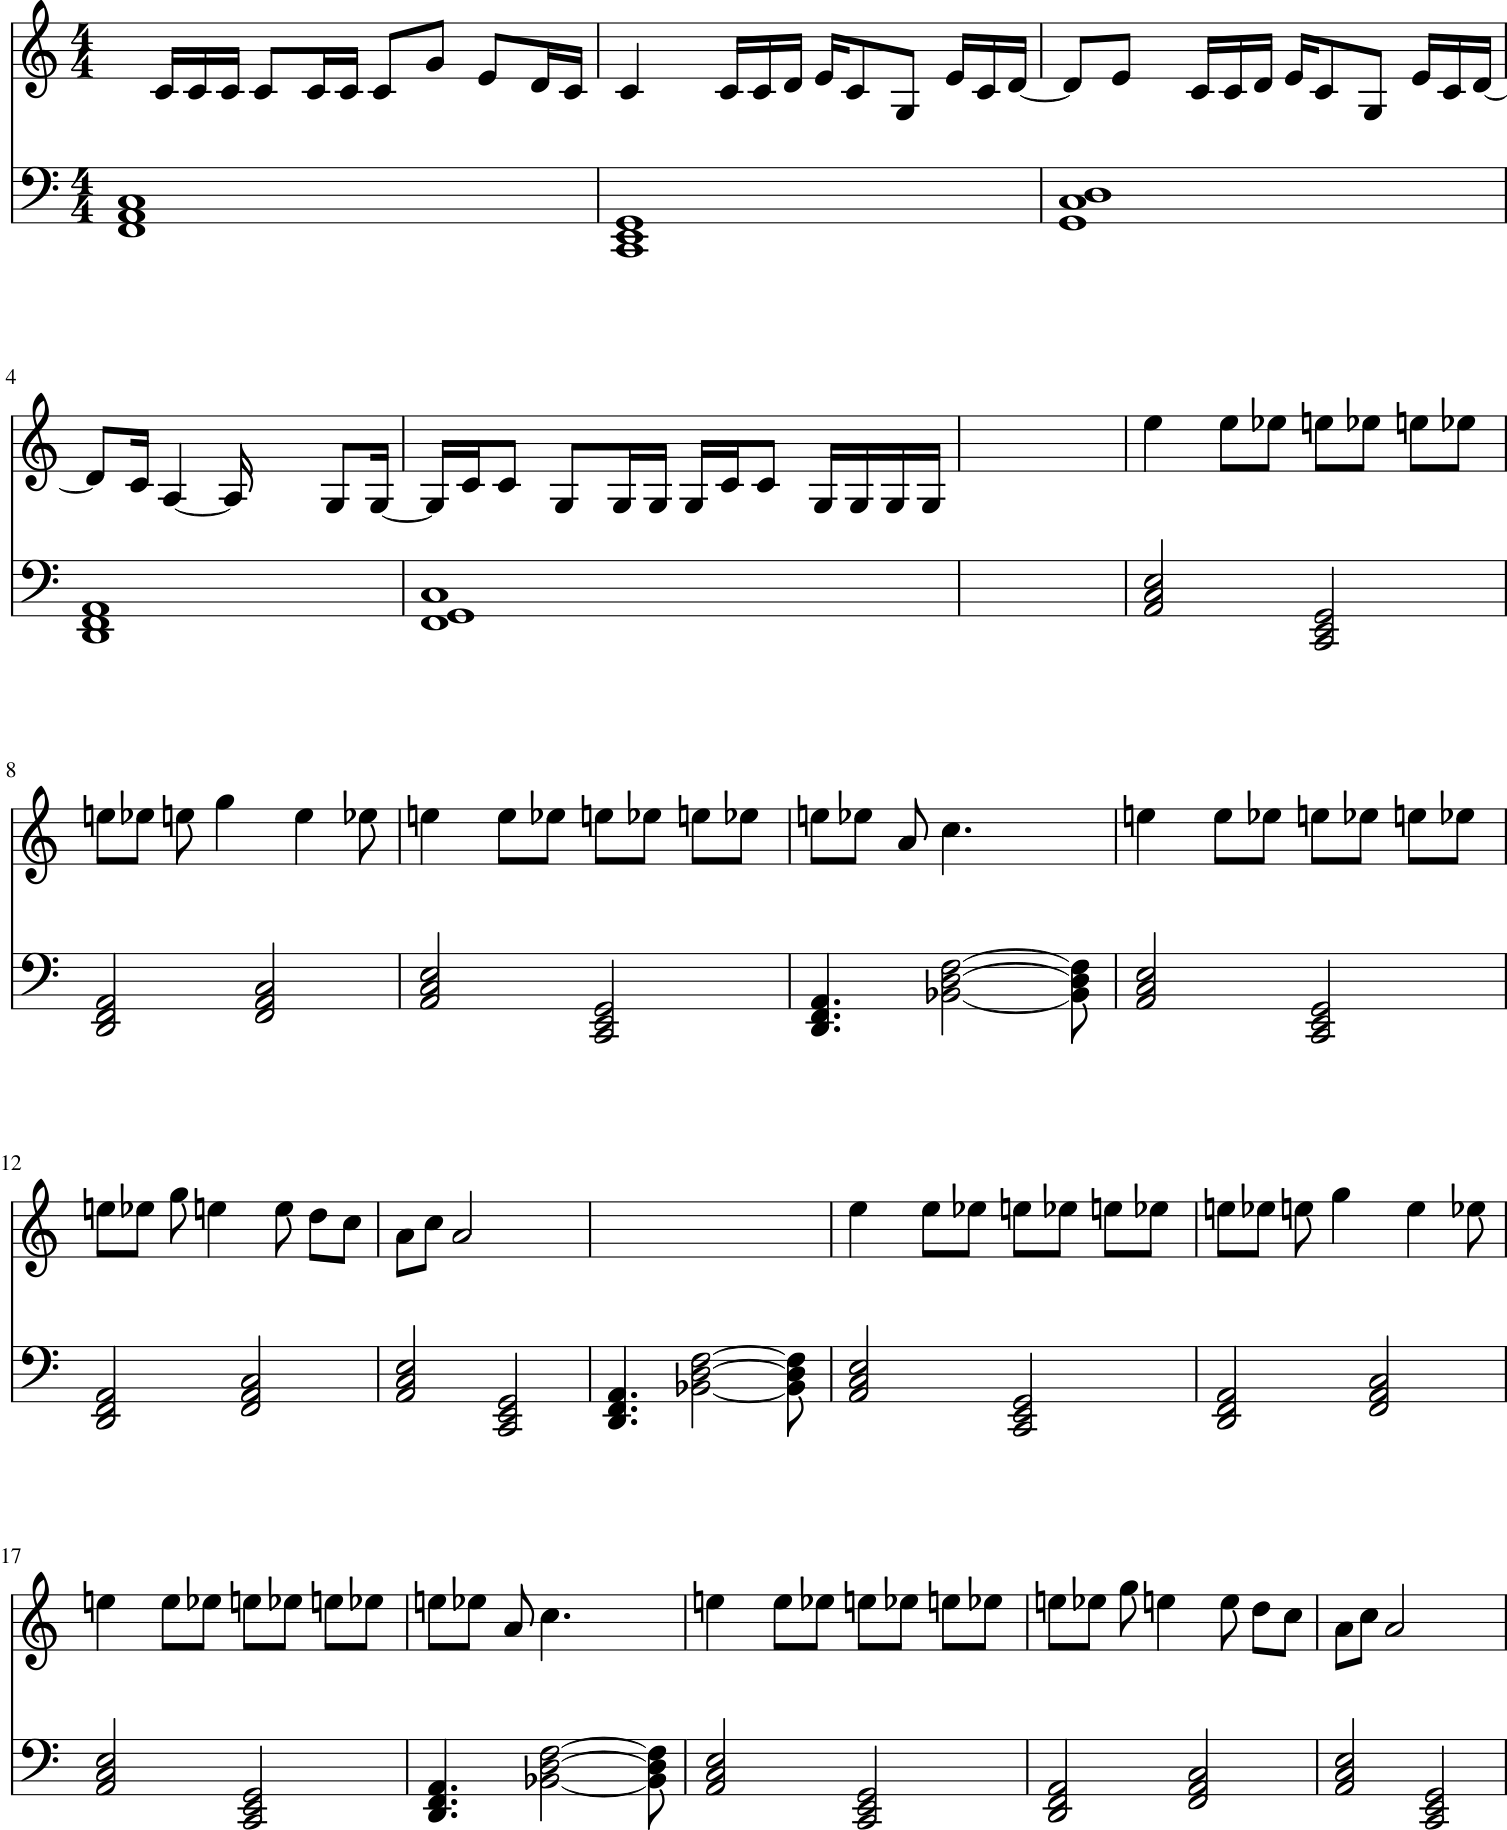

In [85]:
seed_stream.show()

In [86]:
seed_stream.show('midi')

In [87]:
ht_encode.config.bos_idx

-1

In [88]:
xb_offset = (np.array(xb)-ht_encode.config.enc_offset); xb_offset.shape
(xb_offset==ht_encode.config.bos_idx).sum(axis=(2,3))

array([[ 0,  0,  0,  0, ...,  0,  0, 32,  0],
       [ 0, 32,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0, 32, ...,  0,  0,  0,  0],
       [ 0, 32,  0,  0, ...,  0, 32,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0, 32],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0, 32, ...,  0, 32,  0,  0]])

In [89]:
xb_offset.shape

(8, 24, 16, 11)

In [90]:
out_offset = (np.array(out)-ht_encode.config.enc_offset); out_offset.shape
(out_offset==ht_encode.config.bos_idx).sum(axis=(1,2))

array([0, 2, 3, 5, 3, 4, 3, 5, 2, 6])

In [91]:
song = dec_arr(np.array(out)); song

Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustain

Part[0]:
[Chords]:
B(abs=2.0:dur=0.25) C([[sd=4:oct=0, sd=6:oct=0, sd=2:oct=1, sd=1:oct=2]])
B(abs=4.0:dur=0.25) C([[sd=6:oct=0, sd=7:oct=0, sd=5:oct=1, sd=1:oct=2]])
B(abs=8.0:dur=0.25) C([[sd=6:oct=0, sd=7:oct=0, sd=2:oct=1, sd=1:oct=2]])
B(abs=12.0:dur=0.25) C([[sd=4:oct=0, sd=7:oct=0, sd=5:oct=1, sd=5:oct=1]])
B(abs=14.0:dur=0.25) C([[sd=2:oct=0, sd=6:oct=0, sd=3:oct=1, sd=1:oct=2]])
B(abs=20.0:dur=0.25) C([[sd=6:oct=0, sd=1:oct=1, sd=1:oct=1, sd=4:oct=1]])
B(abs=24.0:dur=0.25) C([[sd=4:oct=0, sd=4:oct=0, sd=3:oct=1, sd=1:oct=2]])
B(abs=28.0:dur=0.25) C([[sd=2#:oct=0, sd=7:oct=0, sd=6:oct=1, sd=6:oct=1]])
B(abs=29.0:dur=0.25) C([[sd=6:oct=0, sd=3:oct=1, sd=1:oct=2, sd=7:oct=2]])
B(abs=31.0:dur=0.25) C([[sd=2:oct=0, sd=5#:oct=0, sd=7:oct=0, sd=3:oct=1]])
B(abs=32.0:dur=0.25) C([[sd=2:oct=0, sd=7:oct=0, sd=2:oct=1, sd=3:oct=1]])
B(abs=36.0:dur=0.25) C([[sd=1:oct=0, sd=3:oct=0, sd=5:oct=0, sd=5:oct=0]])

[Notes]:
B(abs=1.5:dur=0.25) P(sd=3:oct=6)
B(abs=2.0:dur=0.25) P(sd=2:oct=5)
B(ab

In [92]:
xb[0]

tensor([[[ 3, 10,  3,  ...,  0,  3,  3],
         [ 3, 10,  3,  ...,  0,  4,  3],
         [ 3, 10,  3,  ...,  0,  4,  3],
         ...,
         [ 6, 10,  7,  ...,  0,  4,  3],
         [ 6, 10,  5,  ...,  0,  4,  3],
         [ 6, 10,  3,  ...,  0,  4,  3]],

        [[ 3,  3,  3,  ...,  0,  3,  3],
         [ 3,  3,  3,  ...,  0,  4,  3],
         [ 3,  3,  3,  ...,  0,  4,  3],
         ...,
         [ 6,  3,  7,  ...,  0,  4,  3],
         [ 6,  3,  3,  ...,  0,  4,  3],
         [ 6,  3,  5,  ...,  0,  4,  3]],

        [[ 3,  4,  5,  ...,  0,  3,  3],
         [ 3,  4,  5,  ...,  0,  4,  3],
         [ 3,  4,  7,  ...,  0,  4,  3],
         ...,
         [ 6,  4,  7,  ...,  0,  4,  3],
         [ 6,  4,  3,  ...,  0,  4,  3],
         [ 6,  4,  5,  ...,  0,  4,  3]],

        ...,

        [[ 3, 10,  0,  ...,  0,  3,  3],
         [ 3, 10,  0,  ...,  0,  4,  3],
         [ 3, 10,  0,  ...,  0,  4,  3],
         ...,
         [ 6, 10,  0,  ...,  0,  4,  3],
         [ 6, 10,  0, 

In [93]:
arr = np.array(out)
arr = arr-ht_encode.config.enc_offset

In [94]:
arr

array([[[ 0,  1,  9,  6, ..., 11,  9,  1,  0],
        [ 0,  1,  4,  5, ...,  7,  7, -2,  0],
        [ 0,  1,  7,  5, ...,  0,  7,  1,  0],
        [ 0,  1,  4,  5, ...,  2,  9,  1,  0],
        ...,
        [ 3,  1,  4,  5, ...,  9,  2,  1,  0],
        [ 3,  1,  4,  6, ...,  2,  9,  1,  0],
        [ 3,  1,  5,  7, ...,  2, 11,  1,  0],
        [ 3,  1,  4,  6, ...,  7, 11,  1,  0]],

       [[ 0,  2,  6,  5, ...,  7,  0,  0,  0],
        [ 0,  2,  2,  5, ...,  4,  7,  1,  0],
        [ 0,  2,  7,  5, ...,  2,  2,  1,  0],
        [ 0,  2,  0,  6, ...,  0,  4,  1,  0],
        ...,
        [ 3,  2,  2,  5, ...,  0,  4,  1,  0],
        [ 3,  2,  2,  5, ..., 11,  7,  1,  2],
        [ 3,  2,  4,  6, ...,  2,  9, -2,  0],
        [ 3,  2,  7,  5, ...,  5,  2,  1,  0]],

       [[ 0,  3,  2,  6, ...,  2,  0,  0,  0],
        [ 0,  3,  4,  4, ...,  7,  0, -2,  0],
        [ 0,  3,  9,  5, ...,  0,  4,  1,  0],
        [ 0,  3,  9,  6, ...,  4,  0,  1,  0],
        ...,
        [ 3,  3, 

In [95]:
if (arr[0] == ht_encode.config.bos_idx).any():
    arr = arr[1:]

In [96]:
arr[0].shape

(16, 11)

In [97]:
arr[0] == ht_encode.config.bos_idx

array([[False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       ...,
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False]])

In [98]:
stream = song.to_stream()

In [99]:
stream.show('text')

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.stream.Part 0x7f4d915aaf98>
    {0.0} <music21.stream.Part 0x7f4d915aaeb8>
        {1.5} <music21.note.Note E>
        {2.0} <music21.note.Note D>
        {2.5} <music21.note.Note E>
        {2.75} <music21.note.Note C>
        {3.0} <music21.note.Note E>
        {3.5} <music21.note.Note F>
        {4.0} <music21.note.Note F#>
        {4.75} <music21.note.Note C>
        {5.5} <music21.note.Note E>
        {6.0} <music21.note.Note G>
        {7.0} <music21.note.Note D>
        {7.25} <music21.note.Note D>
        {8.5} <music21.note.Note A>
        {9.0} <music21.note.Note F>
        {9.75} <music21.note.Note C>
        {10.0} <music21.note.Note F>
        {13.5} <music21.note.Note E>
        {13.75} <music21.note.Note A>
        {14.0} <music21.note.Note F>
        {15.0} <music21.note.Note A>
        {16.0} <music21.note.Note A>
        {16.5} <music21.note.Note G>
        {17.5} <music21.note.Note E>
        {18.0} <music21.note.

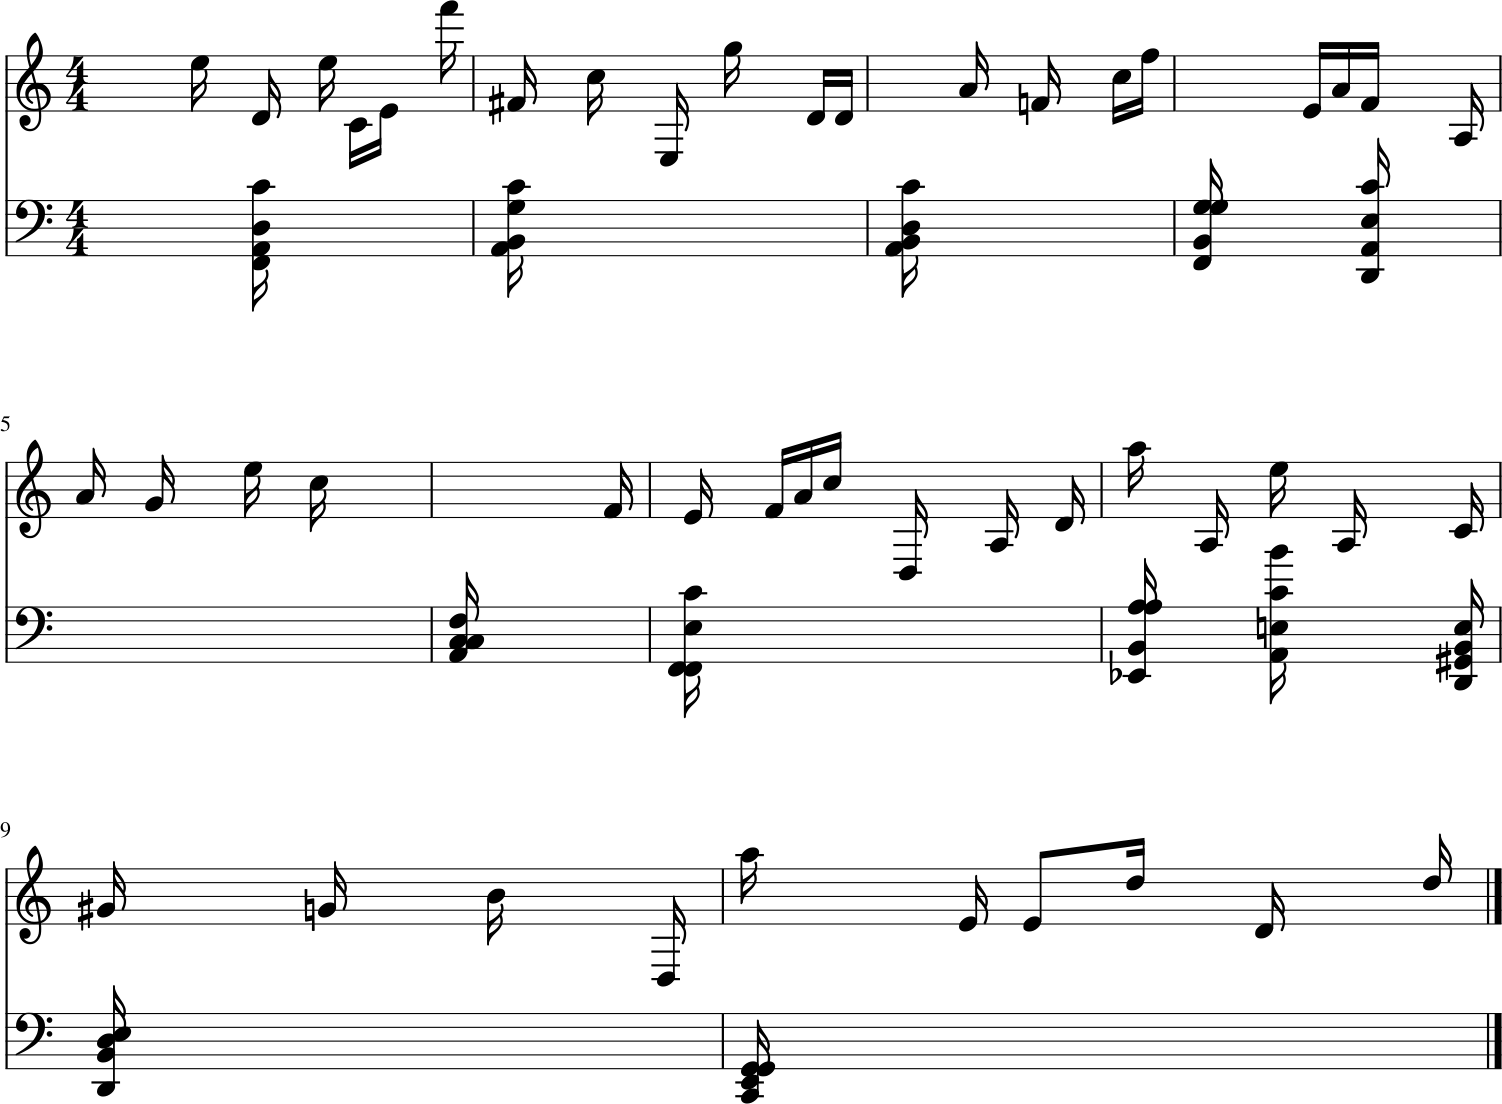

In [100]:
stream.show()

In [101]:
stream.show('midi')